# How to use EnergyMeter
EnergyMeter allows us to measure the energy consumption of code on Python, segregating their energy usage per component (CPU, DRAM, GPU and 
Hard Disk).

We will first introduce how to use EnergyMeter with a minimal example in which we will use numpy to perform some calculations. We create the EnergyMeter by giving it the parameters of the energy consumption of the hard drive (TODO: set reasonable default params so these are optional) and we also give it a label, that will be used to report the results later on.

All we need to do afterwards, is to run meter.begin() before running the code we want to measure and meter.end() after running the code.

In [1]:
from energy_meter import EnergyMeter
import time
import numpy as np

meter = EnergyMeter(disk_avg_speed=1600*1e6, 
                            disk_active_power=6, 
                            disk_idle_power=1.42, 
                            label="Matrix Multiplication", include_idle=False)
meter.begin()
(np.random.rand(300,300)**5)*1/np.random.rand(300,300)
meter.end()

 You need to install pymongo>=3.9.0 in order to use MongoOutput 


We can now see how the energy was spent while running our code. For this, we can use the methods get_total_jules_per_component() or plot_total_jules_per_component() to check how much energy was spent while running the code and how the energy was distributed in the computer components.

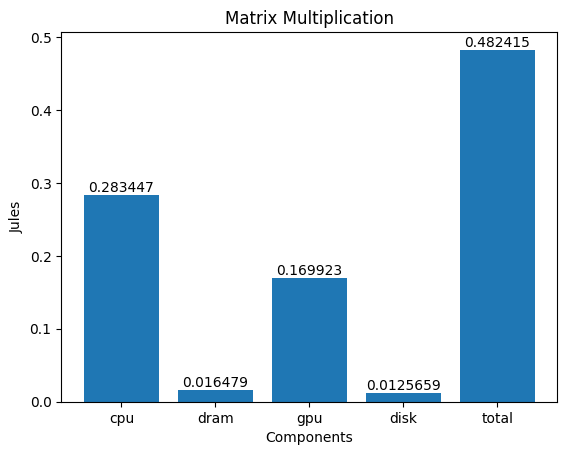

In [4]:
meter.plot_total_jules_per_component()

Note that even if our code did not write or read anything to disk, the plot indicates that the disk used some energy. This is because we also measure the energy used by the disk while being idle.

## A more interesting example
Let's test EnergyMeter in a more interesting example: measuring the energy consumption of performing inference with a Convolutional Neural Network, more specifically VGG16.

In [5]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch
import json
import torchvision

transforms = torchvision.transforms.Compose([
    torchvision.transforms.transforms.Resize(size=256),
    torchvision.transforms.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.transforms.ToTensor(),
    torchvision.transforms.transforms.Normalize(mean=torch.Tensor([0.4850, 0.4560, 0.4060]), 
                                                 std=torch.Tensor([0.2290, 0.2240, 0.2250])),
])

# the json file where the output must be stored
json_file = open("imagenet_labels.json", "r")
imagenet_dict = json.load(json_file)
json_file.close()

def predict(model, img):
    output = model(img)
    top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)
    return top5_probabilities, top5_class_indices.tolist()[0]

def preprocess_data(img):
    # unsqueeze single image into batch of 1.
    return transforms(img).unsqueeze(0)

model = timm.create_model('vgg16.tv_in1k', pretrained=True)
model = model.eval()
model

# If we run this twice, the GPU seems to be preprocessing the image when
# we run the CPU test. In order to avoid it, it's necessary to load the
# model again, so it seems something remains in the GPU even after running
# model.to("cpu").

img = Image.open(urlopen(
    'https://unsplash.com/photos/DwxlhTvC16Q/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MXx8bWVyY2VkZXMlMjBjYXJ8ZW58MHx8fHwxNjg2NzA1MzUyfDA&force=true&w=640'
))

# CPU
# Disk in LSD15 has an avg i/o speed of 1600MB/s and 
# a power consumption of 6W when active and 1.42W when idle.
meter_cpu = EnergyMeter(disk_avg_speed=1600*1e6, 
                        disk_active_power=6, 
                        disk_idle_power=1.42, 
                        label="CPU Inference")
model = model.to("cpu")

meter_cpu.begin()
for _ in range(200):
    p_img = preprocess_data(img).to("cpu")
    probs, labels = predict(model, p_img)
meter_cpu.end()

# To ensure samples from GPU power stats are not mixed up.
time.sleep(1)

meter_gpu = EnergyMeter(disk_avg_speed=1600*1e6, 
                        disk_active_power=6, 
                        disk_idle_power=1.42, 
                        label="GPU Inference")
model = model.to("cuda:0")
meter_gpu.begin()
for _ in range(200):
    p_img = preprocess_data(img).to("cuda:0")
    probs, labels = predict(model, p_img)
meter_gpu.end()

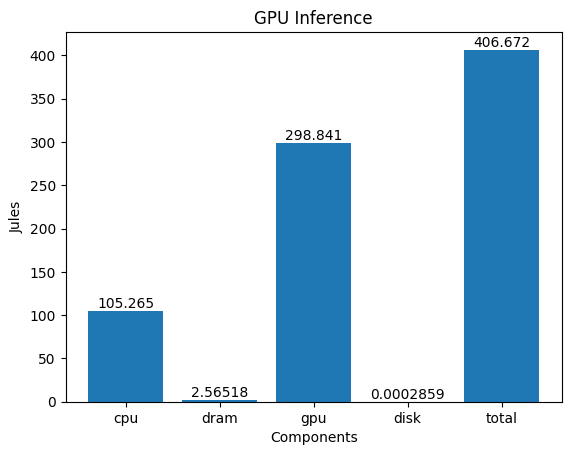

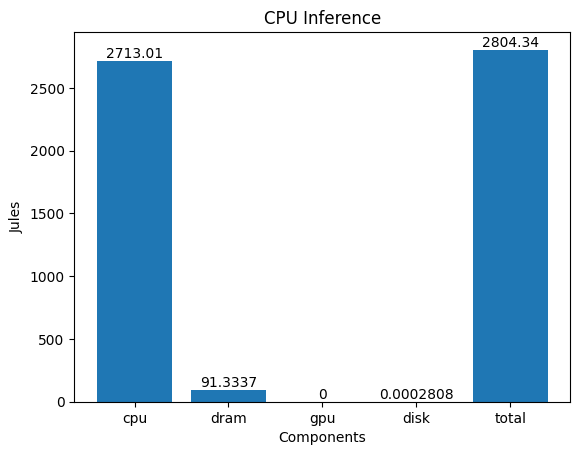

In [6]:
meter_gpu.plot_total_jules_per_component()
meter_cpu.plot_total_jules_per_component()

# The overhead of EnergyMeter
We test the overhead of using the EnergyMeter. For this, we run inference for 100 and 1000 times with and without the EnergyMeter.

In [7]:
# Calculating the overhead of the meter.
def inference_with_meter(model, img, n_inference):
    meter_overhead = EnergyMeter(disk_avg_speed=1600*1e6, 
                            disk_active_power=6, 
                            disk_idle_power=1.42, 
                            label="Inference")
    meter_overhead.begin()
    for _ in range(n_inference):
        p_img = preprocess_data(img).to("cuda:0")
        probs, labels = predict(model, p_img)
    meter_overhead.end()

def inference_without_meter(model, img, n_inference):
    for _ in range(n_inference):
        p_img = preprocess_data(img).to("cuda:0")
        probs, labels = predict(model, p_img)

In [8]:
%timeit inference_with_meter(model, img, n_inference=100)

952 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit inference_without_meter(model, img, n_inference=100)

629 ms ± 806 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit inference_with_meter(model, img, n_inference=1000)

6.74 s ± 250 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit inference_without_meter(model, img, n_inference=1000)

6.31 s ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We see that the EnergyMeter adds an overhead of around 300ms to the original task and that this overhead is constant.

## How does this overhead affect the code between meter.begin() and meter.end()?
Even though we have measured the overhead of the meter, this measurement included everything from creating the meter, starting and finishing it. However, the overhead between meter.begin() and meter.end() is the most important one because it's affecting the normal functioning of the code that we want to profile.

We will perform the same measurements as before but only timing the model's inference (leaving out the creation of the energy meter and its begin() and end() methods).

In [12]:
meter_overhead = EnergyMeter(disk_avg_speed=1600*1e6, 
                            disk_active_power=6, 
                            disk_idle_power=1.42, 
                            label="Inference")
meter_overhead.begin()
%timeit inference_without_meter(model, img, n_inference=100)
meter_overhead.end()

634 ms ± 7.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
meter_overhead = EnergyMeter(disk_avg_speed=1600*1e6, 
                            disk_active_power=6, 
                            disk_idle_power=1.42, 
                            label="Inference")
meter_overhead.begin()
%timeit inference_without_meter(model, img, n_inference=1000)
meter_overhead.end()

6.32 s ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We see that the time measured for inference while running our meter for 100 and 1000 images is (almost) the same as without it. This is because the main overhead is in the begin() and end() methods, so we can assume that the code inside these two calls is a fair representation of what we would see without our meter.